**Problem Statement**

To recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

**Performance Metric**

log-loss

Binary Confusion Matrix


**Mapping the real world problem to an ML problem**

It is a binary classification Problem

In [2]:
#importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
#from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

print('done')


done


In [3]:
data = pd.read_csv('creditcard.csv',sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5974 entries, 0 to 5973
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    5974 non-null   int64  
 1   V1      5974 non-null   float64
 2   V2      5974 non-null   float64
 3   V3      5974 non-null   float64
 4   V4      5974 non-null   float64
 5   V5      5974 non-null   float64
 6   V6      5974 non-null   float64
 7   V7      5974 non-null   float64
 8   V8      5974 non-null   float64
 9   V9      5974 non-null   float64
 10  V10     5974 non-null   float64
 11  V11     5974 non-null   float64
 12  V12     5974 non-null   float64
 13  V13     5974 non-null   float64
 14  V14     5974 non-null   float64
 15  V15     5974 non-null   float64
 16  V16     5974 non-null   float64
 17  V17     5974 non-null   float64
 18  V18     5973 non-null   float64
 19  V19     5973 non-null   float64
 20  V20     5973 non-null   float64
 21  V21     5973 non-null   float64
 22  

#Exploratory Data Analysis

#Checking Null Values

In [5]:
data.isnull().values.any()

True

#Distribution of data points among output class

Text(0, 0.5, 'Frequency')

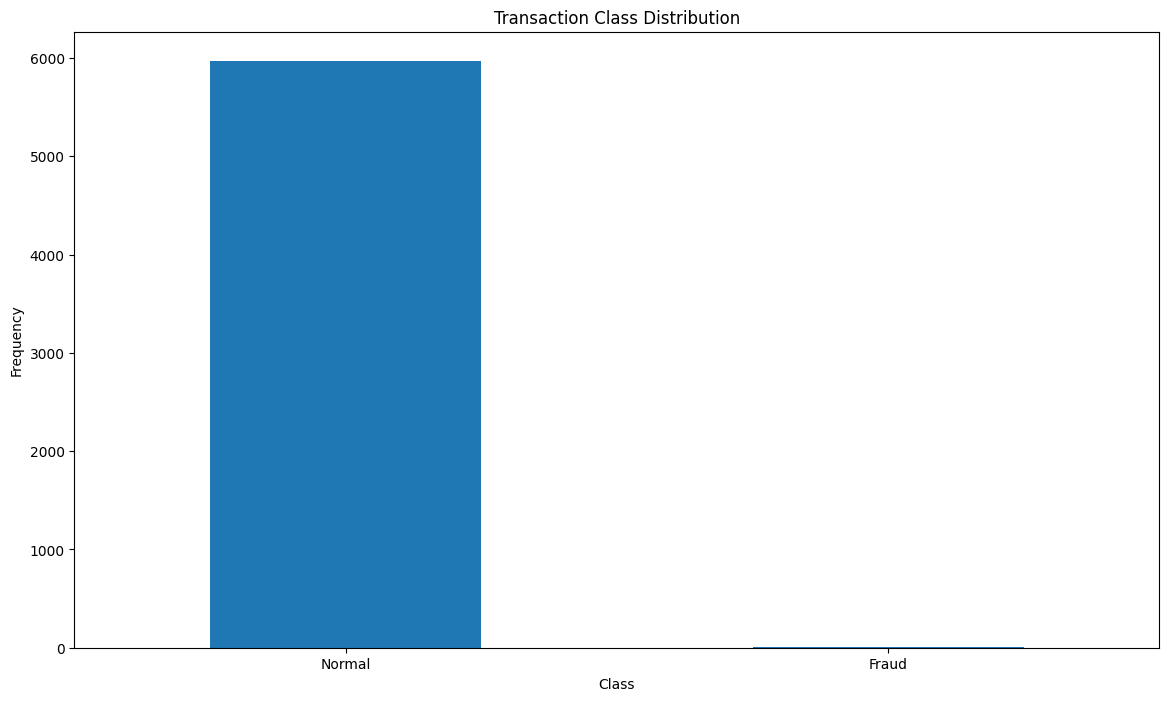

In [6]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

count_classes = pd.value_counts(data['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

#Obervations

1.Normal Transactions is greater than 250k and fraud is very less.

2.We can easily Conclude that this is Highly imbalanced dataset.

In [7]:
## Get the Fraud and the normal dataset

fraud = data[data['Class']==1]

normal = data[data['Class']==0]


In [8]:
print(fraud.shape,normal.shape)


(3, 31) (5970, 31)


In [9]:
## We need to analyze more amount of information from the transaction data
#How different are the amount of money used in different transaction classes?
fraud.Amount.describe()

count      3.000000
mean     256.310000
std      264.880121
min        0.000000
25%      119.965000
50%      239.930000
75%      384.465000
max      529.000000
Name: Amount, dtype: float64

In [10]:
normal.Amount.describe()

count    5970.000000
mean       64.965707
std       192.429839
min         0.000000
25%         4.450000
50%        15.620000
75%        56.485000
max      7712.430000
Name: Amount, dtype: float64

#Transactions with respect to amount by class

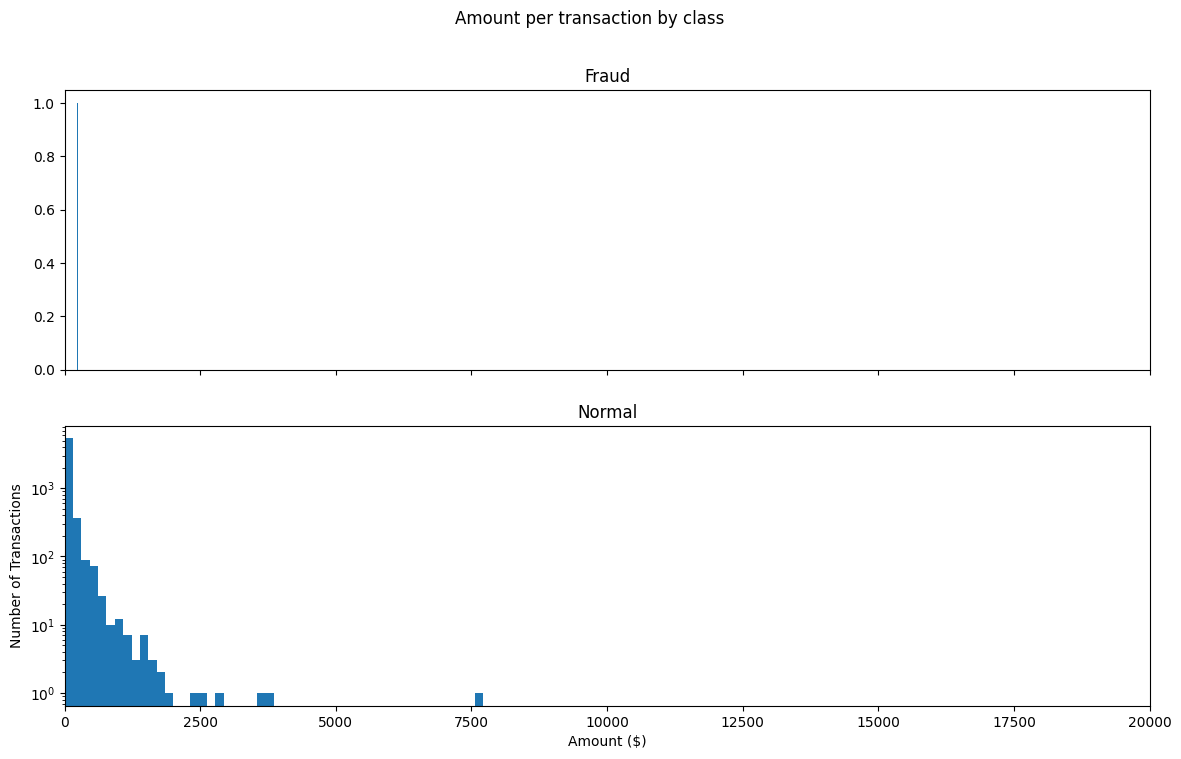

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();


#Observations

1.Transaction for fraud with respect to the amount is very Less.

2.Transaction for normal with respect to the amount is high

#Transactions with respect time of transaction vs amount by class.

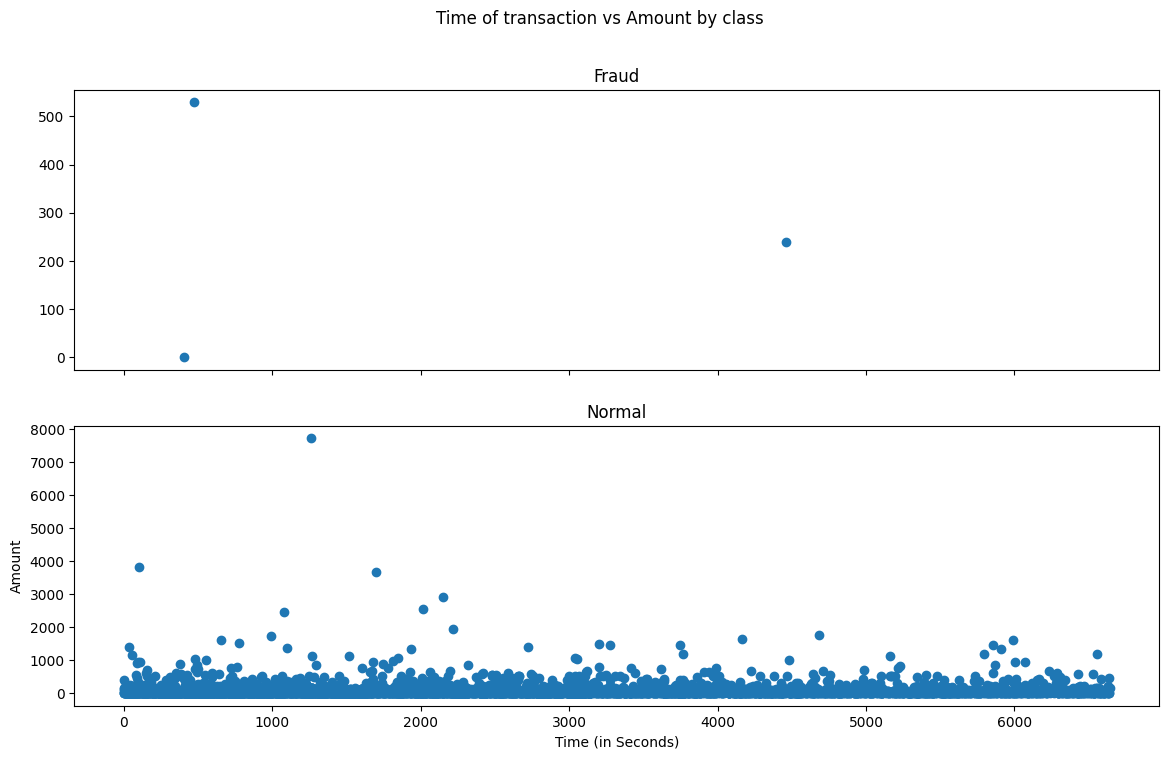

In [12]:
# We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()


#Observations
1.There is lot of overlapping the data points so cant make much sense out of it.


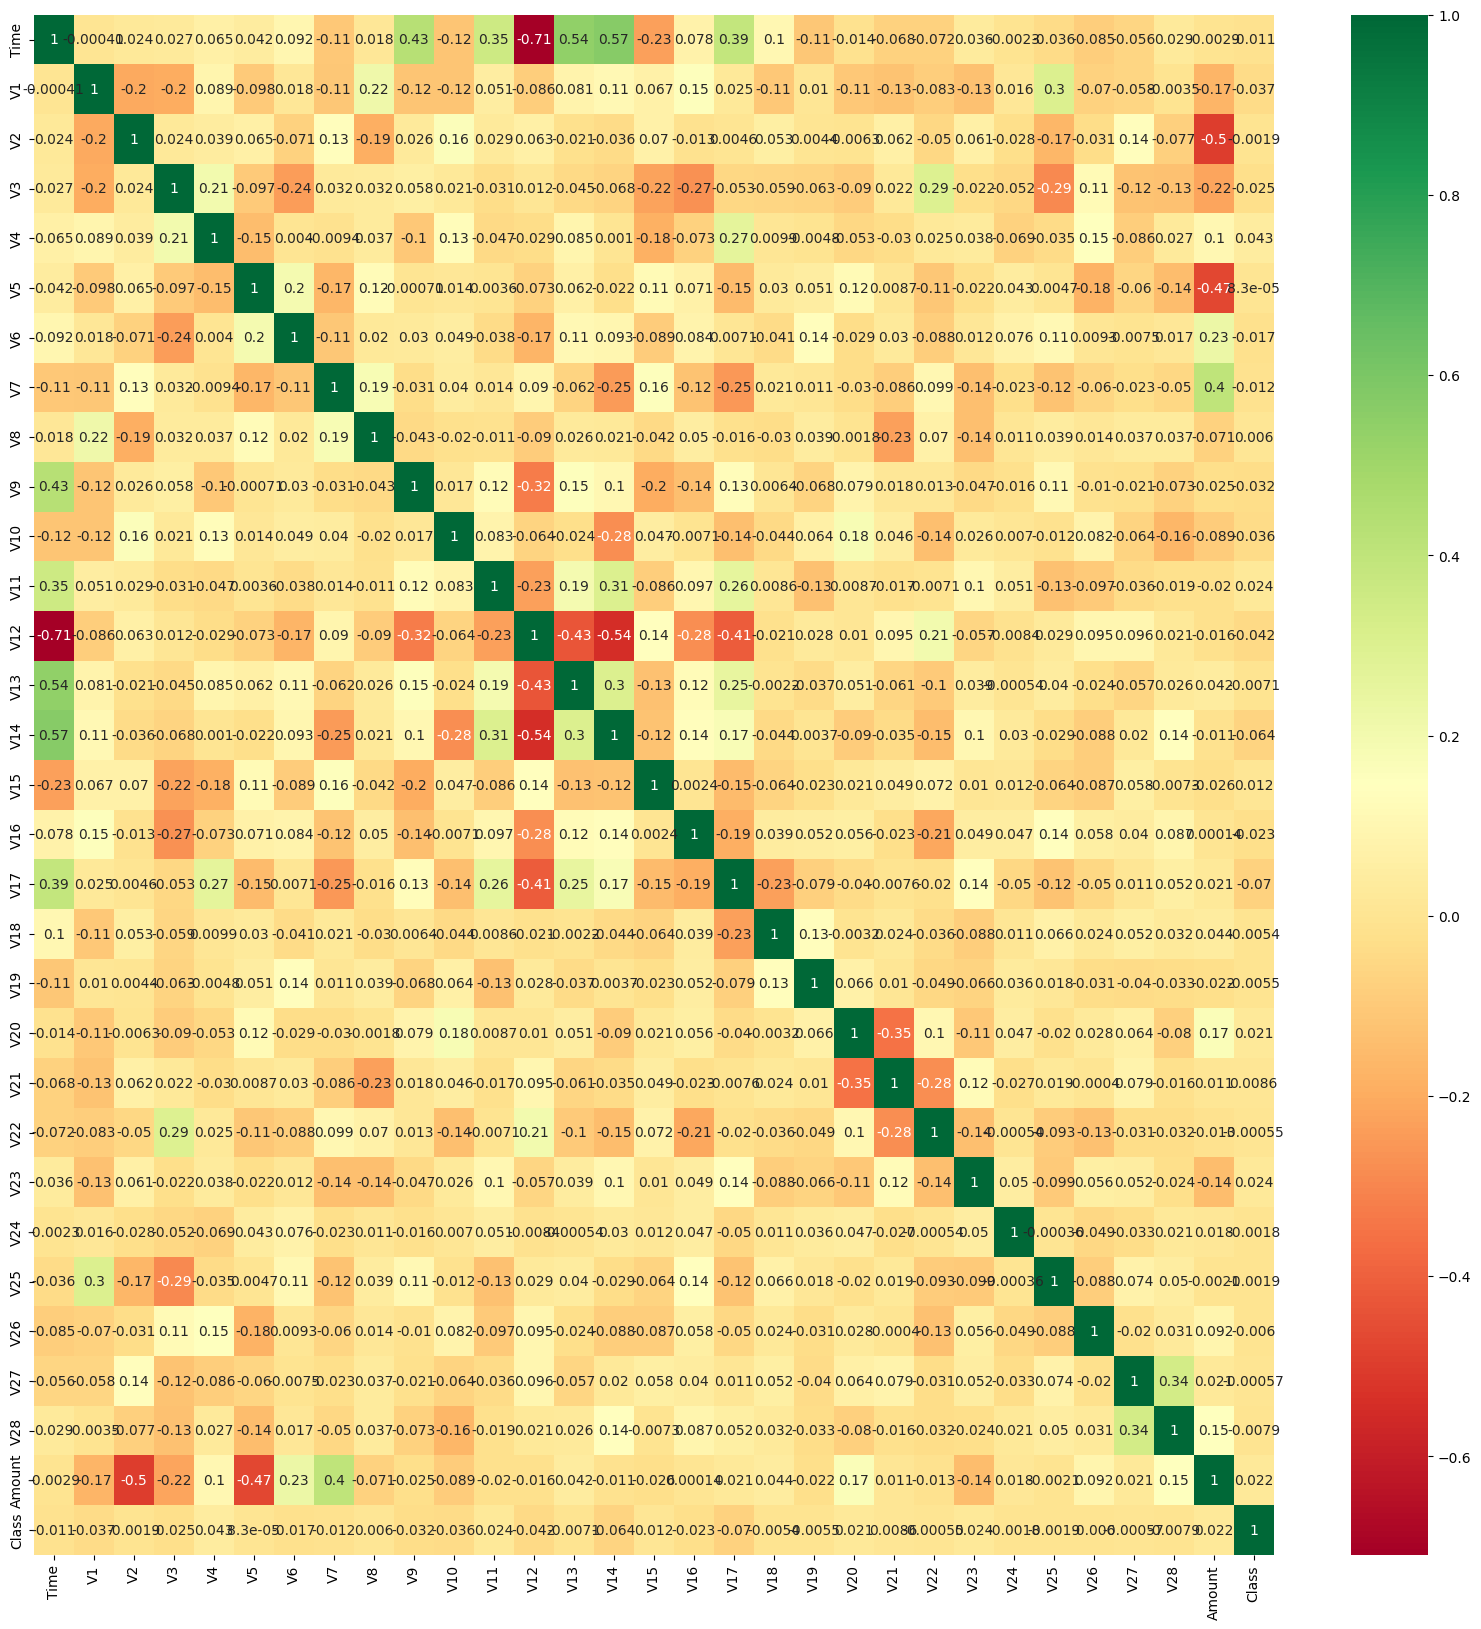

In [14]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

#Train and Test Dataset Construction using undersampling

In [15]:
X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

number_records_fraud = len (data[data.Class==1])


fraud_indices = np.array (data[data.Class==1].index)
normal_indices = np.array (data[data.Class==0].index)


random_normal_indices = np.random.choice (normal_indices, number_records_fraud, replace = False )

under_sample_indices = np.concatenate ([fraud_indices, random_normal_indices])


under_sample_data = data.iloc[under_sample_indices,:]

X_undersample = under_sample_data.iloc [:, under_sample_data.columns != 'Class'];
y_undersample = under_sample_data.iloc [:, under_sample_data.columns == 'Class'];


from sklearn.model_selection import train_test_split
#X_train_old, X_test, y_train, y_test = train_test_split (X,y, test_size = 0.3, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split (X_undersample,y_undersample, test_size = 0.3, random_state = 0)


In [17]:
count_classes = pd.value_counts(y_train['Class'], sort = True)
print(count_classes)

count_classes = pd.value_counts(y_test['Class'], sort = True)
print(count_classes)

1.0    2
0.0    2
Name: Class, dtype: int64
0.0    1
1.0    1
Name: Class, dtype: int64


#Distribution of data points among output classes of train and test data

Text(0, 0.5, 'Frequency')

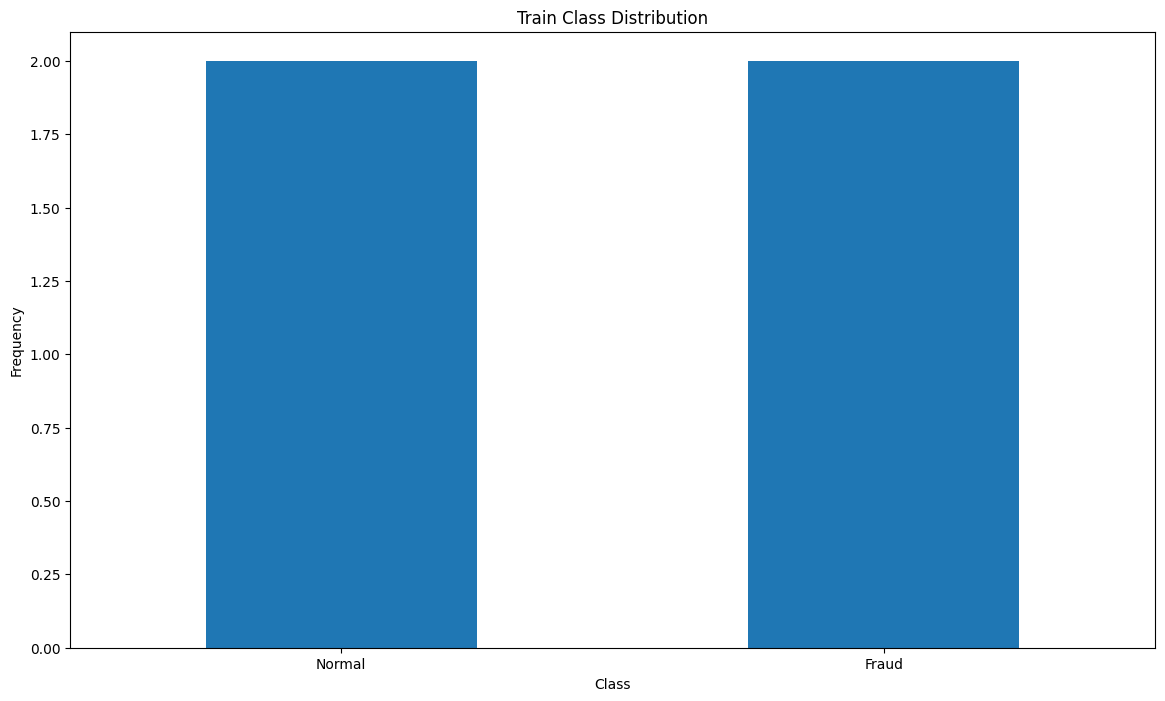

In [18]:
count_classes = pd.value_counts(y_train['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Train Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

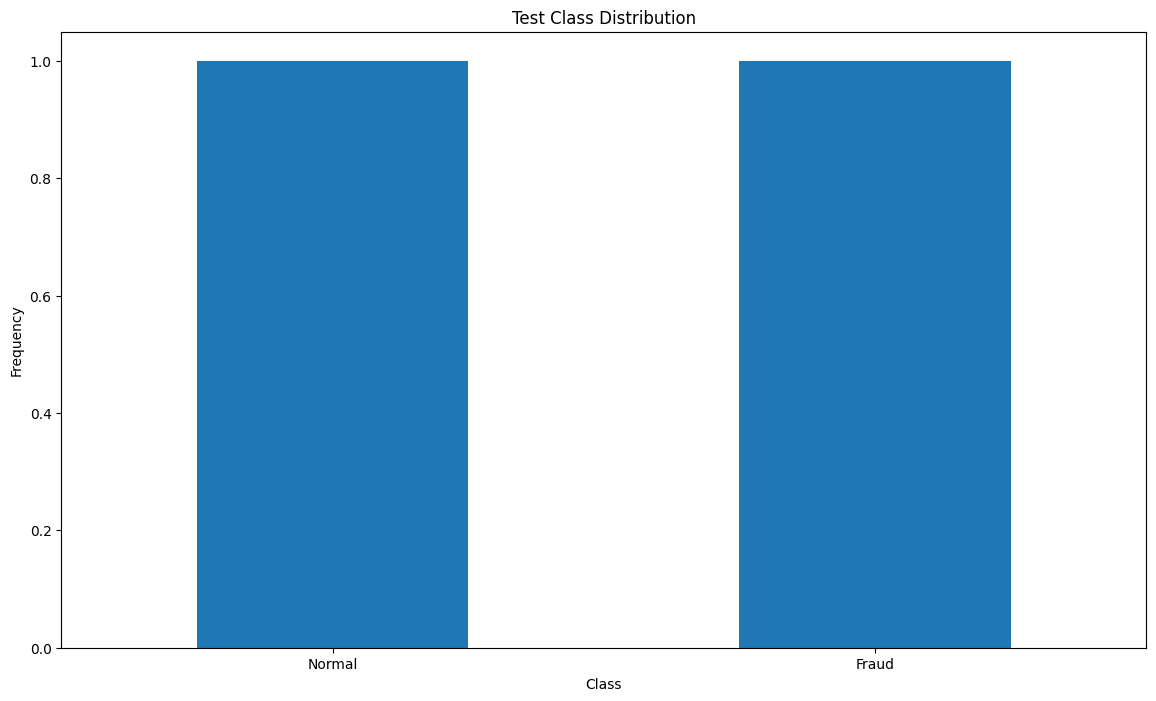

In [19]:
count_classes = pd.value_counts(y_test['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Test Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

#Observations

1.Number of Normal and Fraud Transactions Are Almost Equal.


2.Now we have balanced dataset.


In [20]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (4, 30)
Number of data points in test data : (2, 30)


In [21]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j

    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column


    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row

    plt.figure(figsize=(20,4))

    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    plt.show()

#Machine Learning Models

#XGBoost

In [26]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.69315	valid-logloss:0.69315
[10]	train-logloss:0.69315	valid-logloss:0.69315
[19]	train-logloss:0.69315	valid-logloss:0.69315
The test log loss is: 0.6931471805599453


Total number of data points : 2


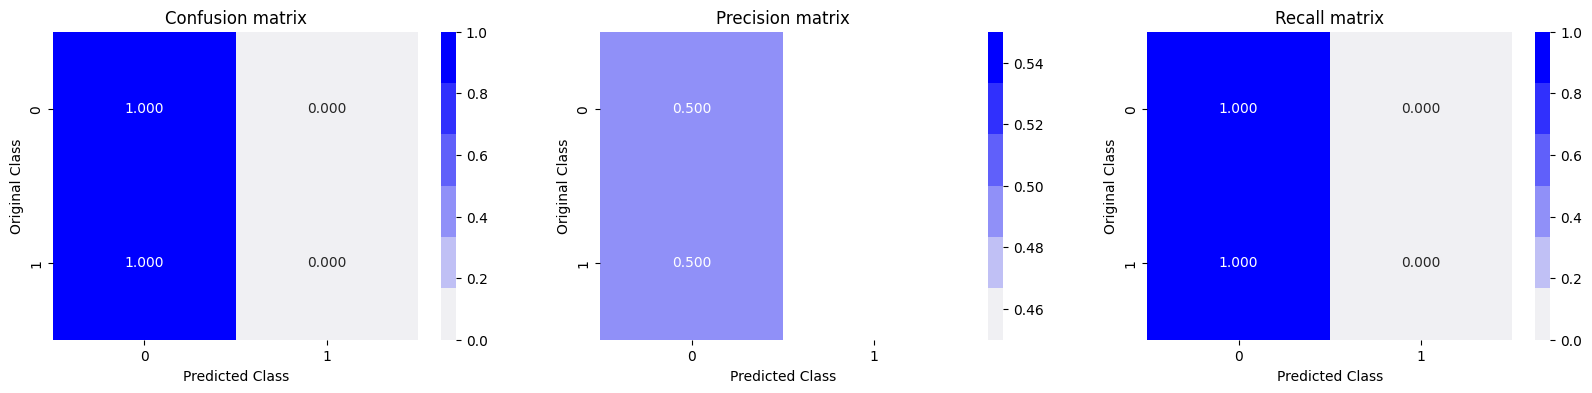

In [27]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

#Observations
1.Log Loss of XGBoost is 0.16 is less


2.Precision for class label 1(fraud) is 96.4% and recall is 91.8 % ,which is very good.

3.Precision for class label 0(normal) is 92.3% and recall is 96.6 % ,which is very good.

#Final Conclusions

1.We can also reduce this loss by increasing the sample size(oversampling) or use deep learning algorithms however at the cost of computational expense.